In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from pathlib import Path

# --- Style Settings ---
import scienceplots
plt.style.use(["science", "ieee"])
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["text.usetex"] = False

# Force white background (overrides style defaults for safety)
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["savefig.facecolor"] = "white"

# --- Constants ---
PLOT_WSPACE = -0.15
VERTICAL_OFFSET_2D = 0.02
BOX_ASPECT_2D = 0.7
Z_LABEL_PAD = 9
TITLE_PAD_2D = 20
LEGEND_NCOL = 4
LEGEND_X = 0.5
LEGEND_Y = -0.18

CHAIN_LENGTH = 16
DATA_FILE = Path("tfim_l16_entangle_rbm_20251212_030007.csv")
REF_FILE = Path(f"tfim_{CHAIN_LENGTH}_entropy_ref.csv")

In [2]:
# --- Load Data ---
df_res = pd.read_csv(DATA_FILE)
ref_df = pd.read_csv(REF_FILE)

# --- Process RBM Data for 3D Surface ---
# Pivot to create a matrix (l rows, h columns)
pivot_df = df_res.pivot(index="l", columns="h", values="s2")

# Extract axes for meshgrid
h_dense = pivot_df.columns.values.astype(float)
l_values = pivot_df.index.values.astype(int)

# Create Meshgrid (X=h, Y=l, Z=s2)
X_h, Y_l = np.meshgrid(h_dense, l_values)
Z_s2 = pivot_df.values

# Identify specific 'h' values to plot in 2D cuts (where type is 'support')
support_h_keys = np.sort(
    df_res[df_res["type"] == "support"]["h"].unique()
)

# --- Clean Reference Data ---
ref_df["h"] = ref_df["h"].astype(float)

print(f"Data Loaded.")
print(f"h range: {h_dense.min()} to {h_dense.max()}")
print(f"l range: {l_values.min()} to {l_values.max()}")
print(f"Support cuts found: {len(support_h_keys)}")

Data Loaded.
h range: 0.5 to 1.5
l range: 1 to 8
Support cuts found: 7


In [ ]:
# --- Figure Setup ---
fig = plt.figure(figsize=(16, 6), dpi=150)
fig.patch.set_facecolor("white")

gs = gridspec.GridSpec(
    1, 2,
    width_ratios=[1.6, 0.8],
    wspace=PLOT_WSPACE
)

# ==========================================
# 1. 3D SURFACE PLOT
# ==========================================
ax3d = fig.add_subplot(gs[0], projection="3d")
ax3d.set_proj_type("ortho")

# --- Grid & Ticks Configuration ---
ax3d.minorticks_off()
ax3d.xaxis.set_minor_locator(ticker.NullLocator())
ax3d.yaxis.set_minor_locator(ticker.NullLocator())
ax3d.zaxis.set_minor_locator(ticker.NullLocator())

ax3d.xaxis.set_major_locator(ticker.MultipleLocator(0.2))  # h axis
ax3d.yaxis.set_major_locator(ticker.MultipleLocator(1))    # ℓ axis
ax3d.zaxis.set_major_locator(ticker.MultipleLocator(0.1))  # z axis

ax3d.set_box_aspect((1, 1, 0.65))

grid_style = {"color": "gray", "linewidth": 0.5, "alpha": 0.3}
for axis in (ax3d.xaxis, ax3d.yaxis, ax3d.zaxis):
    axis._axinfo["grid"].update(grid_style)
    axis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# --- Plot Surface (viridis, but low h -> LIGHT) ---
cmap_surface = plt.get_cmap("viridis")
norm_h = mcolors.Normalize(vmin=h_dense.min(), vmax=h_dense.max())

t = norm_h(X_h)          # 0..1 with increasing h
t = 1.0 - t              # invert so low h maps to bright viridis
t = 0.10 + 0.85 * t      # avoid the very darkest tail

surface_colors = cmap_surface(t)

ax3d.plot_surface(
    X_h, Y_l, Z_s2,
    facecolors=surface_colors,
    rstride=1,
    cstride=1,
    shade=True,
    linewidth=0,
    alpha=1.0,
    antialiased=True
)

# --- Labels & View ---
ax3d.set_zlim(np.min(Z_s2) - 0.05, np.max(Z_s2) + 0.1)
ax3d.set_xlabel("Transverse Field $h$", fontsize=12, labelpad=10)
ax3d.set_ylabel("Subsystem Size $\\ell$", fontsize=12, labelpad=10)
ax3d.set_zlabel(r"Rényi Entropy $S_2$", fontsize=12, labelpad=Z_LABEL_PAD)
ax3d.view_init(elev=30, azim=-40)


# ==========================================
# 2. 2D CUTS PLOT
# ==========================================
ax2d = fig.add_subplot(gs[1])
ax2d.set_facecolor("white")
ax2d.set_box_aspect(BOX_ASPECT_2D)

# Adjust Position
pos = ax2d.get_position()
ax2d.set_position([
    pos.x0,
    pos.y0 + VERTICAL_OFFSET_2D,
    pos.width,
    pos.height
])

cmap_2d = plt.get_cmap("tab10")
ref_label_added = False

for i, h in enumerate(support_h_keys):
    subset = df_res[df_res["h"] == h].sort_values("l")
    s2_vals = subset["s2"].values
    err_vals = subset["s2_err"].values
    color = cmap_2d(i % 10)

    # A. 3D cuts: continuous solid colored lines (no underlay, no dashes)
    ax3d.plot(
        np.full_like(l_values, h, dtype=float),
        l_values,
        s2_vals,
        color=color,
        linestyle="-",
        linewidth=2.2,
        alpha=1.0,
        zorder=20
    )

    # B. Reference Data (ED)
    mask = np.isclose(ref_df["h"].values, h, atol=1e-6)
    if mask.any():
        row = ref_df.loc[mask].iloc[0]
        x_ref, y_ref = [], []
        for c in ref_df.columns:
            if c.startswith("l"):
                ell = int(c[1:])
                if ell in l_values:
                    x_ref.append(ell)
                    y_ref.append(row[c])

        lbl = "ED Reference" if not ref_label_added else "_nolegend_"
        ax2d.plot(x_ref, y_ref, "--", color="#444444", lw=1.2, label=lbl, zorder=5)
        ref_label_added = True

    # C. RBM Data
    ax2d.plot(
        l_values, s2_vals,
        marker="o", linestyle="-", color=color, markersize=5,
        linewidth=1.5, alpha=0.9, markeredgecolor="white", markeredgewidth=0.5,
        label=f"h={h:.2f}", zorder=4
    )
    ax2d.fill_between(
        l_values, s2_vals - err_vals, s2_vals + err_vals,
        color=color, alpha=0.2, linewidth=0
    )

# --- 2D Styling ---
ax2d.set_xlabel("Subsystem size $\\ell$", fontsize=12)
ax2d.set_title("TFIM L16 - Rényi Entropy", fontsize=14, pad=TITLE_PAD_2D)
ax2d.legend(frameon=True, fontsize=9, loc="upper center", bbox_to_anchor=(LEGEND_X, LEGEND_Y), ncol=LEGEND_NCOL)
ax2d.grid(True, which="major", alpha=0.3, color="gray", linewidth=0.5)

plt.show()


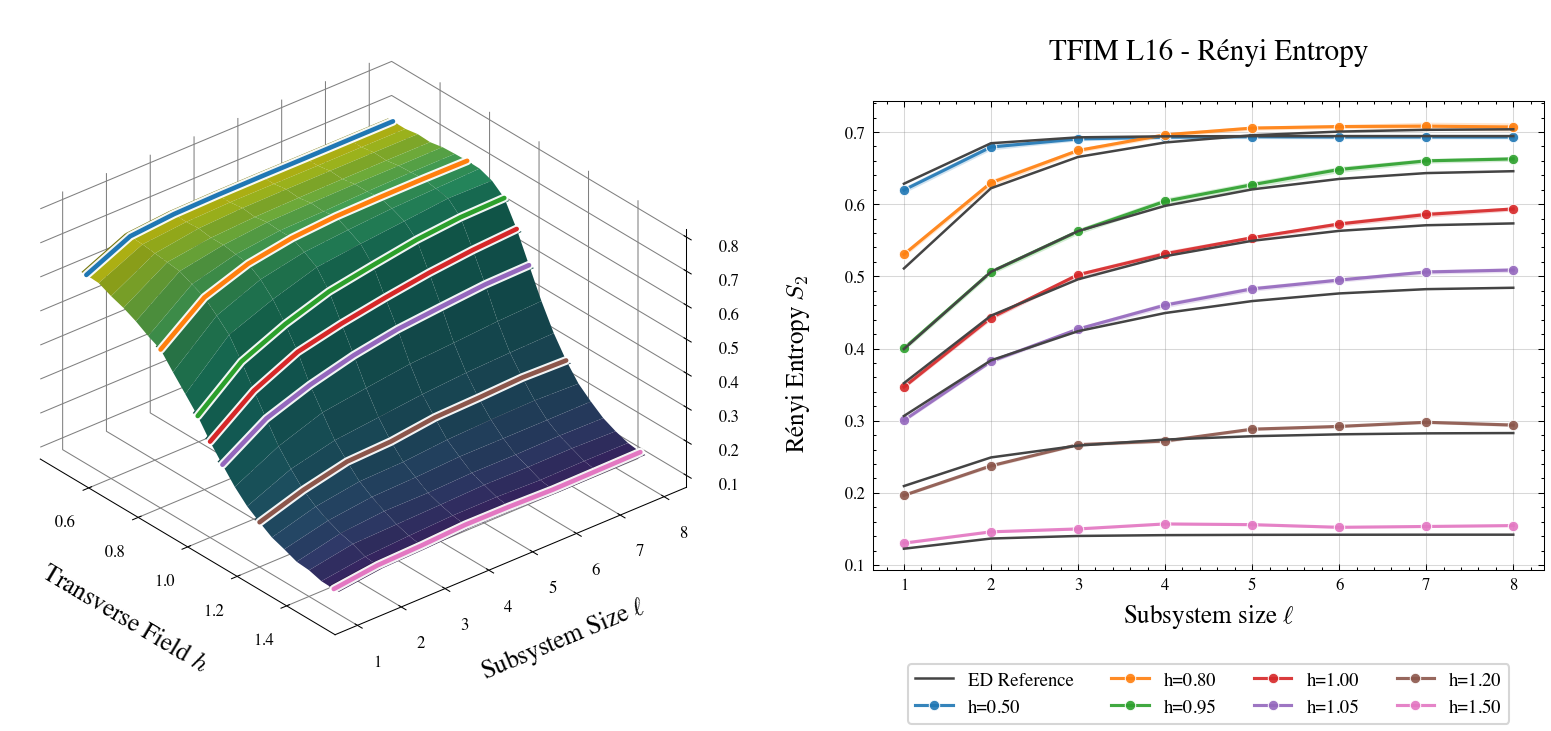

In [4]:
# --- Figure Setup ---
fig = plt.figure(figsize=(16, 6), dpi=150)
fig.patch.set_facecolor("white")

gs = gridspec.GridSpec(
    1, 2,
    width_ratios=[1.6, 0.8],
    wspace=PLOT_WSPACE
)

# ==========================================
# 1. 3D SURFACE PLOT
# ==========================================
ax3d = fig.add_subplot(gs[0], projection="3d")
ax3d.set_proj_type("ortho")

# --- Grid & Ticks Configuration ---
ax3d.minorticks_off()
ax3d.xaxis.set_minor_locator(ticker.NullLocator())
ax3d.yaxis.set_minor_locator(ticker.NullLocator())
ax3d.zaxis.set_minor_locator(ticker.NullLocator())

ax3d.xaxis.set_major_locator(ticker.MultipleLocator(0.2))  # h axis
ax3d.yaxis.set_major_locator(ticker.MultipleLocator(1))    # ℓ axis
ax3d.zaxis.set_major_locator(ticker.MultipleLocator(0.1))  # z axis

ax3d.set_box_aspect((1, 1, 0.65))

grid_style = {"color": "gray", "linewidth": 0.5, "alpha": 0.3}
for axis in (ax3d.xaxis, ax3d.yaxis, ax3d.zaxis):
    axis._axinfo["grid"].update(grid_style)
    axis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# --- Plot Surface (viridis, but low h -> LIGHT) ---
cmap_surface = plt.get_cmap("viridis")
norm_h = mcolors.Normalize(vmin=h_dense.min(), vmax=h_dense.max())

t = norm_h(X_h)          # 0..1 with increasing h
t = 1.0 - t              # invert so low h maps to bright viridis
t = 0.10 + 0.85 * t      # avoid the very darkest tail

surface_colors = cmap_surface(t)

ax3d.plot_surface(
    X_h, Y_l, Z_s2,
    facecolors=surface_colors,
    rstride=1,
    cstride=1,
    shade=True,
    linewidth=0,
    alpha=1.0,
    antialiased=True
)

# --- Labels & View ---
ax3d.set_zlim(np.min(Z_s2) - 0.05, np.max(Z_s2) + 0.1)
ax3d.set_xlabel("Transverse Field $h$", fontsize=12, labelpad=10)
ax3d.set_ylabel("Subsystem Size $\\ell$", fontsize=12, labelpad=10)
ax3d.set_zlabel(r"Rényi Entropy $S_2$", fontsize=12, labelpad=Z_LABEL_PAD)
ax3d.view_init(elev=30, azim=-40)


# ==========================================
# 2. 2D CUTS PLOT
# ==========================================
ax2d = fig.add_subplot(gs[1])
ax2d.set_facecolor("white")
ax2d.set_box_aspect(BOX_ASPECT_2D)

# Adjust Position
pos = ax2d.get_position()
ax2d.set_position([
    pos.x0,
    pos.y0 + VERTICAL_OFFSET_2D,
    pos.width,
    pos.height
])

cmap_2d = plt.get_cmap("tab10")
ref_label_added = False

H_RIBBON_PAD = 0.02  # <-- the "extra surface" width on each side of the cut

for i, h in enumerate(support_h_keys):
    subset = df_res[df_res["h"] == h].sort_values("l")
    s2_vals = subset["s2"].values
    err_vals = subset["s2_err"].values
    color = cmap_2d(i % 10)

    # A0. Add a thin surface ribbon around the cut so the glow has background at the edges
    h0 = float(h)
    h_left  = h0 - H_RIBBON_PAD
    h_right = h0 + H_RIBBON_PAD

    X_rib = np.vstack([
        np.full_like(l_values, h_left, dtype=float),
        np.full_like(l_values, h_right, dtype=float),
    ])
    Y_rib = np.vstack([l_values, l_values])
    Z_rib = np.vstack([s2_vals, s2_vals])

    # use the same viridis mapping as the main surface (at h0)
    t0 = 1.0 - norm_h(h0)
    t0 = 0.10 + 0.85 * t0
    rib_color = cmap_surface(t0)

    ax3d.plot_surface(
        X_rib, Y_rib, Z_rib,
        color=rib_color,
        shade=True,
        linewidth=0,
        alpha=1.0,
        antialiased=True
    )

    # A. 3D cuts: continuous solid lines + white under-stroke (glow)
    xline = np.full_like(l_values, h0, dtype=float)

    ax3d.plot(
        xline, l_values, s2_vals,
        color="white",
        linestyle="-",
        linewidth=4.2,
        alpha=0.95,
        solid_capstyle="round",
        solid_joinstyle="round",
        zorder=19
    )
    ax3d.plot(
        xline, l_values, s2_vals,
        color=color,
        linestyle="-",
        linewidth=2.2,
        alpha=1.0,
        solid_capstyle="round",
        solid_joinstyle="round",
        zorder=20
    )

    # B. Reference Data (ED) - SOLID (no dashes)
    mask = np.isclose(ref_df["h"].values, h0, atol=1e-6)
    if mask.any():
        row = ref_df.loc[mask].iloc[0]
        x_ref, y_ref = [], []
        for c in ref_df.columns:
            if c.startswith("l"):
                ell = int(c[1:])
                if ell in l_values:
                    x_ref.append(ell)
                    y_ref.append(row[c])

        lbl = "ED Reference" if not ref_label_added else "_nolegend_"
        ax2d.plot(x_ref, y_ref, "-", color="#444444", lw=1.2, label=lbl, zorder=5)
        ref_label_added = True

    # C. RBM Data (unchanged)
    ax2d.plot(
        l_values, s2_vals,
        marker="o", linestyle="-", color=color, markersize=5,
        linewidth=1.5, alpha=0.9, markeredgecolor="white", markeredgewidth=0.5,
        label=f"h={h0:.2f}", zorder=4
    )
    ax2d.fill_between(
        l_values, s2_vals - err_vals, s2_vals + err_vals,
        color=color, alpha=0.2, linewidth=0
    )

# --- 2D Styling ---
ax2d.set_xlabel("Subsystem size $\\ell$", fontsize=12)
ax2d.set_title("TFIM L16 - Rényi Entropy", fontsize=14, pad=TITLE_PAD_2D)
ax2d.legend(frameon=True, fontsize=9, loc="upper center", bbox_to_anchor=(LEGEND_X, LEGEND_Y), ncol=LEGEND_NCOL)
ax2d.grid(True, which="major", alpha=0.3, color="gray", linewidth=0.5)

plt.show()
